# Healthcare Workforce Survey Analysis
## Northwest Arkansas Regional Health Workforce Needs Assessment

This notebook provides a comprehensive analysis of the healthcare workforce survey data, including:
- Data quality assessment
- Healthcare domain insights
- Automated tagging system
- Interactive visualizations
- Key findings and recommendations


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading and Initial Exploration


In [4]:
# Load the survey data
df = pd.read_excel('data/Need_Assessment_Survey.xlsx', sheet_name='Sheet1')

print(f"Dataset Overview:")
print(f"- Total responses: {len(df)}")
print(f"- Total questions: {len(df.columns)}")
print(f"- Survey period: {df['Start time'].min()} to {df['Start time'].max()}")
print(f"- Data shape: {df.shape}")


Dataset Overview:
- Total responses: 67
- Total questions: 24
- Survey period: 2024-11-22 11:29:00 to 2025-07-31 09:42:52
- Data shape: (67, 24)


In [5]:
# Clean column names for easier analysis
column_mapping = {}
for i, col in enumerate(df.columns):
    short_name = f"Q{i:02d}_{col[:50].replace(' ', '_').replace('?', '').replace(',', '').replace('(', '').replace(')', '')}"
    column_mapping[col] = short_name

# Display column mapping
print("Column Reference Guide:")
for orig, short in list(column_mapping.items())[:10]:  # Show first 10
    print(f"  {short}: {orig[:60]}{'...' if len(orig) > 60 else ''}")
print("  ... (and more)")

# Display the full dataset structure
print(f"\nFull Column List:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")


Column Reference Guide:
  Q00_Start_time: Start time
  Q01_Completion_time: Completion time
  Q02_Organization : Organization 
  Q03_Organization_County: Organization County
  Q04_Department_Type: Department Type
  Q05_Role/Position: Role/Position
  Q06_Length_of_time_in_current_position: Length of time in current position
  Q07_Contact_Email: Contact Email
  Q08_I_consent_to_being_contacted_by_a_member_of_the_He: I consent to being contacted by a member of the Heartland Wh...
  Q09_What_skills_resources_or_knowledge_are_a_priorit: What skills, resources, or knowledge are a priority as you t...
  ... (and more)

Full Column List:
 1. Start time
 2. Completion time
 3. Organization 
 4. Organization County
 5. Department Type
 6. Role/Position
 7. Length of time in current position
 8. Contact Email
 9. I consent to being contacted by a member of the Heartland Whole Health Institute team for additional feedback regarding my responses
10. What skills, resources, or knowledge are a priori

## 2. Data Quality Assessment


In [8]:
# Calculate response rates
response_rates = {}
for col in df.columns:
    non_null_count = df[col].notna().sum()
    response_rate = (non_null_count / len(df)) * 100
    response_rates[col] = response_rate

# Create response rate DataFrame
response_df = pd.DataFrame([
    {'Question': column_mapping.get(col, col)[:50], 
     'Full_Question': col,
     'Response_Rate': rate, 
     'Responses': int(len(df) * rate / 100),
     'Missing': len(df) - int(len(df) * rate / 100)}
    for col, rate in response_rates.items()
])

# Display questions with missing data
incomplete_questions = response_df[response_df['Response_Rate'] < 100].sort_values('Response_Rate')
print("Questions with Missing Data:")
print("=" * 80)
print(incomplete_questions[['Question', 'Response_Rate', 'Missing']].to_string(index=False))

print(f"\n\nData Quality Summary:")
print(f"- Average response rate: {response_df['Response_Rate'].mean():.1f}%")
print(f"- Questions with 100% response rate: {len(response_df[response_df['Response_Rate'] == 100])}")
print(f"- Questions with <50% response rate: {len(response_df[response_df['Response_Rate'] < 50])}")
print(f"- Most incomplete question: {incomplete_questions.iloc[0]['Question']} ({incomplete_questions.iloc[0]['Response_Rate']:.1f}%)")


Questions with Missing Data:
                                          Question  Response_Rate  Missing
                               Q04_Department_Type       0.000000       67
Q17_Which_groups_of_professionals_in_your_organiza       0.000000       67
Q19_How_often_do_individuals_from_your_frontline_h       0.000000       67
Q22_What_facilities_would_you_like_to_see_included       0.000000       67
Q21_Which_of_the_following_features_are_most_impor       0.000000       67
Q20_How_often_would_you_require_interdisciplinary_       0.000000       67
Q18_How_far_are_you_willing_to_travel_to_join_in-p       0.000000       67
Q23_Do_you_have_any_final_comments_or_suggestions_      58.208955       28
Q14_What_are_the_current_training_and_development_      70.149254       20
Q16_Which_groups_of_health_care_professionals_in_y      73.134328       18
Q15_What_specific_actions_are_needed_to_elevate_an      86.567164       10
                           Q03_Organization_County      88.059701      

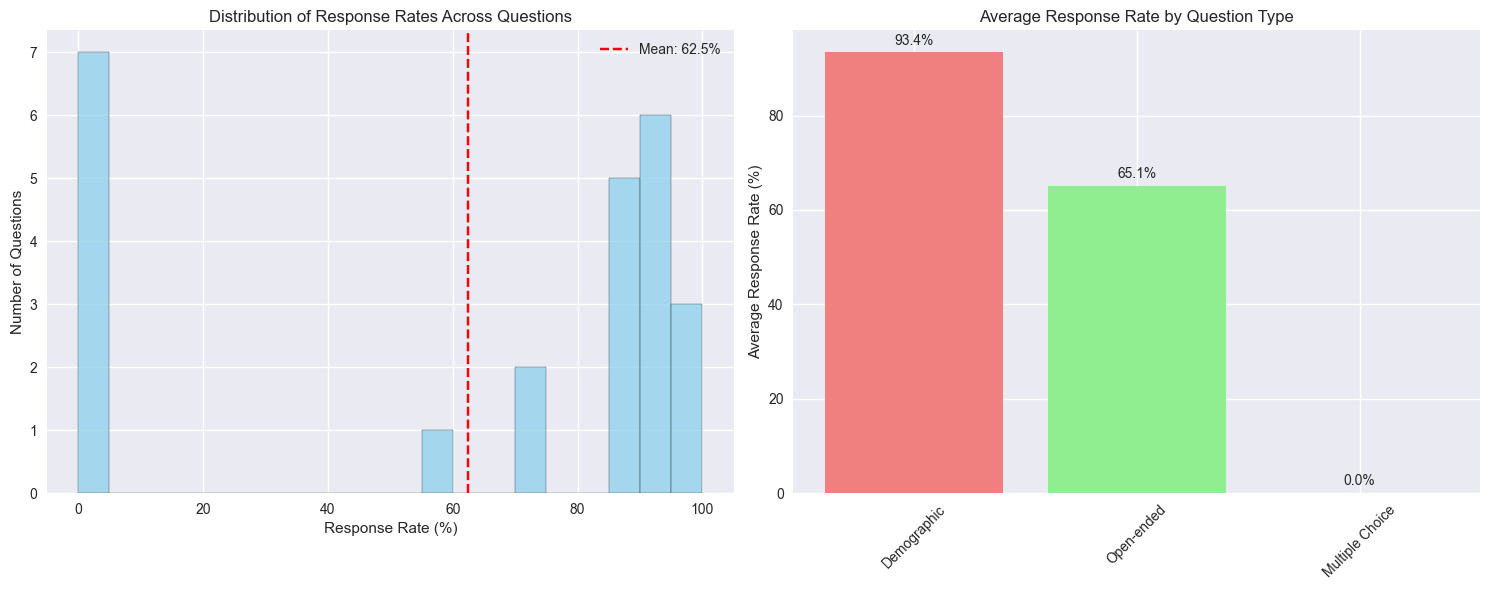


Question Type Analysis:

Demographic Questions:
  Count: 7
  Average response rate: 93.4%
  Range: 88.1% - 100.0%

Multiple Choice Questions:
  Count: 4
  Average response rate: 0.0%
  Range: 0.0% - 0.0%

Open-ended Questions:
  Count: 13
  Average response rate: 65.1%
  Range: 0.0% - 95.5%


In [9]:
# Visualize response rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Response rate distribution
ax1.hist(response_df['Response_Rate'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Response Rate (%)')
ax1.set_ylabel('Number of Questions')
ax1.set_title('Distribution of Response Rates Across Questions')
ax1.axvline(response_df['Response_Rate'].mean(), color='red', linestyle='--', 
           label=f'Mean: {response_df["Response_Rate"].mean():.1f}%')
ax1.legend()

# Missing data by question type
question_types = []
demo_cols = ['organization', 'county', 'role', 'position', 'email', 'time']
mc_cols = ['willing to travel', 'features', 'facilities', 'interdisciplinary', 'often']

for _, row in response_df.iterrows():
    question = row['Question'].lower()
    if any(term in question for term in demo_cols):
        question_types.append('Demographic')
    elif any(term in question for term in mc_cols):
        question_types.append('Multiple Choice')
    else:
        question_types.append('Open-ended')

response_df['Question_Type'] = question_types
type_summary = response_df.groupby('Question_Type')['Response_Rate'].mean().sort_values(ascending=False)

colors = ['lightcoral', 'lightgreen', 'lightsalmon']
bars = ax2.bar(type_summary.index, type_summary.values, color=colors)
ax2.set_ylabel('Average Response Rate (%)')
ax2.set_title('Average Response Rate by Question Type')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, type_summary.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional analysis
print("\nQuestion Type Analysis:")
for qtype, group in response_df.groupby('Question_Type'):
    print(f"\n{qtype} Questions:")
    print(f"  Count: {len(group)}")
    print(f"  Average response rate: {group['Response_Rate'].mean():.1f}%")
    print(f"  Range: {group['Response_Rate'].min():.1f}% - {group['Response_Rate'].max():.1f}%")


## 3. Demographic and Organizational Analysis


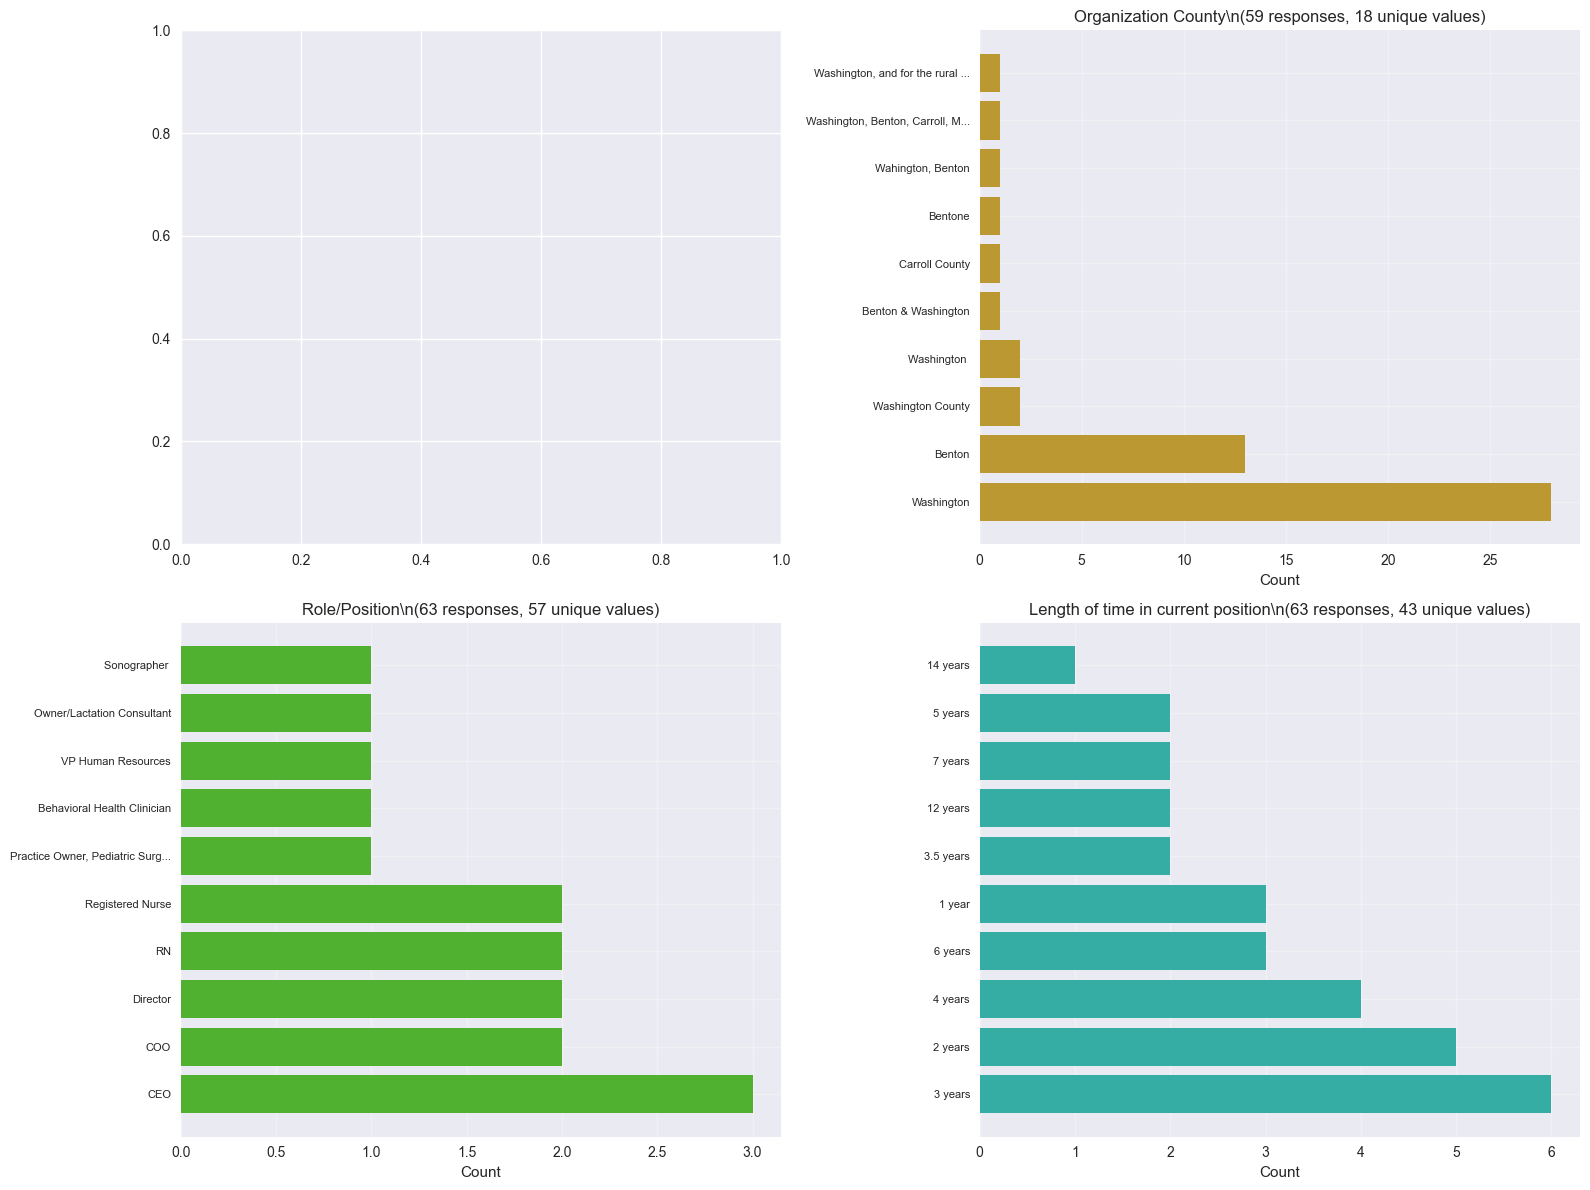

Detailed Demographic Analysis:
\nOrganization County:
  Response rate: 59/67 (88.1%)
  Unique values: 18
  Top responses:
    'Washington': 28 (41.8%)
    'Benton': 13 (19.4%)
    'Washington County': 2 (3.0%)
    'Washington ': 2 (3.0%)
    'Benton & Washington': 1 (1.5%)
    ... and 13 more unique values
\nRole/Position:
  Response rate: 63/67 (94.0%)
  Unique values: 57
  Top responses:
    'CEO': 3 (4.5%)
    'COO': 2 (3.0%)
    'Director': 2 (3.0%)
    'RN': 2 (3.0%)
    'Registered Nurse': 2 (3.0%)
    ... and 52 more unique values
\nLength of time in current position:
  Response rate: 63/67 (94.0%)
  Unique values: 43
  Top responses:
    '3 years': 6 (9.0%)
    '2 years': 5 (7.5%)
    '4 years': 4 (6.0%)
    '6 years': 3 (4.5%)
    '1 year': 3 (4.5%)
    ... and 38 more unique values


In [10]:
# Analyze demographic and organizational characteristics
demographic_cols = ['Organization ', 'Organization County', 'Role/Position', 'Length of time in current position']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    if col in df.columns and df[col].notna().any():
        # Get value counts
        value_counts = df[col].value_counts().head(10)  # Top 10 values
        
        # Create visualization
        if len(value_counts) > 8:
            # Use horizontal bar for many categories
            axes[i].barh(range(len(value_counts)), value_counts.values, color=f'C{i}')
            axes[i].set_yticks(range(len(value_counts)))
            axes[i].set_yticklabels([str(x)[:30] + '...' if len(str(x)) > 30 else str(x) 
                                   for x in value_counts.index], fontsize=8)
            axes[i].set_xlabel('Count')
        else:
            # Use regular bar chart
            axes[i].bar(range(len(value_counts)), value_counts.values, color=f'C{i}')
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels([str(x)[:20] + '...' if len(str(x)) > 20 else str(x) 
                                   for x in value_counts.index], rotation=45, ha='right', fontsize=8)
            axes[i].set_ylabel('Count')
        
        axes[i].set_title(f'{col}\\n({df[col].notna().sum()} responses, {df[col].nunique()} unique values)')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed demographic analysis
print("Detailed Demographic Analysis:")
print("=" * 60)

for col in demographic_cols:
    if col in df.columns and df[col].notna().any():
        print(f"\\n{col}:")
        value_counts = df[col].value_counts()
        print(f"  Response rate: {df[col].notna().sum()}/{len(df)} ({df[col].notna().sum()/len(df)*100:.1f}%)")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Top responses:")
        
        for val, count in value_counts.head(5).items():
            percentage = (count / len(df)) * 100
            print(f"    '{val}': {count} ({percentage:.1f}%)")
        
        if len(value_counts) > 5:
            print(f"    ... and {len(value_counts) - 5} more unique values")


## 4. Healthcare Domain Analysis and Tagging System


In [13]:
# Define comprehensive healthcare domain categories
healthcare_categories = {
    'training_development': {
        'keywords': ['training', 'education', 'development', 'skills', 'learning', 'certification', 
                    'competency', 'professional development', 'continuing education', 'simulation',
                    'workshop', 'course', 'curriculum', 'mentoring', 'coaching'],
        'description': 'Training, education, and skill development needs',
        'color': '#1f77b4'
    },
    'recruitment': {
        'keywords': ['recruit', 'hiring', 'attract', 'new graduates', 'pipeline', 'talent acquisition',
                    'onboarding', 'hiring', 'job posting', 'interview', 'selection'],
        'description': 'Strategies and challenges in recruiting healthcare professionals',
        'color': '#ff7f0e'
    },
    'retention': {
        'keywords': ['retain', 'turnover', 'stay', 'keep', 'attrition', 'engagement', 'satisfaction',
                    'loyalty', 'commitment', 'longevity', 'resign', 'quit', 'leaving'],
        'description': 'Retention strategies and factors affecting staff staying',
        'color': '#2ca02c'
    },
    'leadership_management': {
        'keywords': ['leadership', 'management', 'supervision', 'mentoring', 'coaching', 'supervisor', 
                    'manager', 'executive', 'director', 'administrative', 'governance'],
        'description': 'Leadership development and management training needs',
        'color': '#d62728'
    },
    'clinical_competencies': {
        'keywords': ['clinical', 'patient care', 'bedside', 'nursing', 'medical', 'diagnostic', 
                    'therapeutic', 'clinical skills', 'evidence-based', 'practice', 'protocols'],
        'description': 'Clinical skills and patient care competencies',
        'color': '#9467bd'
    },
    'technology_innovation': {
        'keywords': ['technology', 'electronic', 'digital', 'system', 'innovation', 'equipment', 
                    'simulation', 'virtual', 'emr', 'ehr', 'software', 'automation'],
        'description': 'Technology adoption and digital health initiatives',
        'color': '#8c564b'
    },
    'interprofessional_collaboration': {
        'keywords': ['interdisciplinary', 'collaboration', 'teamwork', 'communication', 'interprofessional',
                    'team-based', 'coordination', 'partnership', 'cooperation'],
        'description': 'Team-based care and interprofessional collaboration',
        'color': '#e377c2'
    },
    'resource_constraints': {
        'keywords': ['cost', 'budget', 'funding', 'resources', 'financial', 'money', 'expensive', 'afford',
                    'budget', 'economic', 'investment', 'roi', 'price'],
        'description': 'Financial and resource limitations',
        'color': '#7f7f7f'
    },
    'time_constraints': {
        'keywords': ['time', 'schedule', 'busy', 'coverage', 'staffing', 'hours', 'availability',
                    'workload', 'overtime', 'shift', 'scheduling'],
        'description': 'Time and scheduling challenges',
        'color': '#bcbd22'
    },
    'career_advancement': {
        'keywords': ['career', 'advancement', 'promotion', 'progression', 'mobility', 'growth',
                    'opportunity', 'pathway', 'ladder', 'development'],
        'description': 'Career development and advancement opportunities',
        'color': '#17becf'
    },
    'work_life_balance': {
        'keywords': ['work-life', 'balance', 'wellbeing', 'burnout', 'stress', 'flexibility', 'family',
                    'wellness', 'mental health', 'resilience', 'self-care'],
        'description': 'Work-life balance and wellness initiatives',
        'color': '#ff9896'
    },
    'quality_improvement': {
        'keywords': ['quality', 'improvement', 'outcomes', 'safety', 'best practices', 'standards',
                    'accreditation', 'metrics', 'performance', 'excellence'],
        'description': 'Quality improvement and patient safety initiatives',
        'color': '#98df8a'
    }
}

# Define healthcare roles with expanded keywords
healthcare_roles = {
    'nursing': ['nurse', 'rn', 'lpn', 'cna', 'nursing', 'registered nurse', 'licensed practical nurse'],
    'physicians': ['physician', 'doctor', 'md', 'do', 'hospitalist', 'attending', 'resident', 'fellow'],
    'allied_health': ['therapist', 'technician', 'tech', 'respiratory', 'radiology', 'lab', 'pharmacy',
                     'physical therapy', 'occupational therapy', 'speech therapy', 'social work'],
    'leadership': ['ceo', 'coo', 'director', 'manager', 'supervisor', 'administrator', 'chief',
                  'vice president', 'president', 'executive'],
    'support_staff': ['clerk', 'registration', 'housekeeping', 'transport', 'security', 'maintenance',
                     'food service', 'environmental services']
}

# Define urgency indicators with more nuanced detection
urgency_indicators = {
    'high': ['urgent', 'critical', 'immediate', 'crisis', 'shortage', 'emergency', 'severe',
            'desperate', 'dire', 'pressing', 'acute'],
    'medium': ['important', 'needed', 'priority', 'significant', 'essential', 'necessary',
              'required', 'vital', 'key'],
    'low': ['would like', 'prefer', 'nice to have', 'future', 'eventually', 'someday',
           'optional', 'ideal', 'wish']
}

print("Healthcare Domain Taxonomy Defined:")
print("=" * 50)
print(f"Healthcare Categories: {len(healthcare_categories)}")
for category, info in healthcare_categories.items():
    print(f"  • {category.replace('_', ' ').title()}: {len(info['keywords'])} keywords")

print(f"\\nHealthcare Roles: {len(healthcare_roles)}")
for role, keywords in healthcare_roles.items():
    print(f"  • {role.replace('_', ' ').title()}: {len(keywords)} keywords")

print(f"\\nUrgency Levels: {len(urgency_indicators)}")
for level, indicators in urgency_indicators.items():
    print(f"  • {level.title()}: {len(indicators)} indicators")


Healthcare Domain Taxonomy Defined:
Healthcare Categories: 12
  • Training Development: 15 keywords
  • Recruitment: 11 keywords
  • Retention: 13 keywords
  • Leadership Management: 11 keywords
  • Clinical Competencies: 11 keywords
  • Technology Innovation: 12 keywords
  • Interprofessional Collaboration: 9 keywords
  • Resource Constraints: 13 keywords
  • Time Constraints: 11 keywords
  • Career Advancement: 10 keywords
  • Work Life Balance: 11 keywords
  • Quality Improvement: 10 keywords
\nHealthcare Roles: 5
  • Nursing: 7 keywords
  • Physicians: 8 keywords
  • Allied Health: 11 keywords
  • Leadership: 10 keywords
  • Support Staff: 8 keywords
\nUrgency Levels: 3
  • High: 11 indicators
  • Medium: 9 indicators
  • Low: 9 indicators


In [14]:
# Define comprehensive tagging functions
def categorize_text(text, categories):
    """Categorize text based on keyword matching with scoring"""
    if pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    found_categories = []
    
    for category, info in categories.items():
        score = 0
        matched_keywords = []
        
        for keyword in info['keywords']:
            if keyword in text_lower:
                score += 1
                matched_keywords.append(keyword)
        
        if score > 0:
            found_categories.append({
                'category': category,
                'score': score,
                'matched_keywords': matched_keywords
            })
    
    # Return categories sorted by relevance score
    return sorted(found_categories, key=lambda x: x['score'], reverse=True)

def extract_urgency(text):
    """Extract urgency level from text with confidence scoring"""
    if pd.isna(text):
        return {'level': 'unknown', 'confidence': 0}
    
    text_lower = str(text).lower()
    urgency_scores = {level: 0 for level in urgency_indicators.keys()}
    
    for level, indicators in urgency_indicators.items():
        for indicator in indicators:
            if indicator in text_lower:
                urgency_scores[level] += 1
    
    # Determine highest scoring level
    max_level = max(urgency_scores.keys(), key=lambda k: urgency_scores[k])
    max_score = urgency_scores[max_level]
    
    if max_score == 0:
        return {'level': 'medium', 'confidence': 0.3}  # default with low confidence
    
    confidence = min(max_score / 3, 1.0)  # Normalize confidence
    return {'level': max_level, 'confidence': confidence}

def extract_roles(text):
    """Extract healthcare roles mentioned in text with context"""
    if pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    found_roles = []
    
    for role_category, keywords in healthcare_roles.items():
        matched_keywords = []
        for keyword in keywords:
            if keyword in text_lower:
                matched_keywords.append(keyword)
        
        if matched_keywords:
            found_roles.append({
                'role': role_category,
                'matched_keywords': matched_keywords,
                'count': len(matched_keywords)
            })
    
    return sorted(found_roles, key=lambda x: x['count'], reverse=True)

def extract_entities(text):
    """Extract additional entities like organizations, locations, numbers"""
    if pd.isna(text):
        return {}
    
    text_str = str(text)
    
    # Extract numbers (percentages, years, counts)
    numbers = re.findall(r'\\b\\d+(?:\\.\\d+)?%?\\b', text_str)
    
    # Extract potential organization names (capitalized words)
    org_patterns = re.findall(r'\\b[A-Z][a-z]+(?:\\s+[A-Z][a-z]+)*\\b', text_str)
    
    # Extract time-related terms
    time_terms = re.findall(r'\\b(?:hours?|days?|weeks?|months?|years?)\\b', text_str.lower())
    
    return {
        'numbers': numbers[:5],  # Limit to first 5
        'potential_orgs': org_patterns[:3],  # Limit to first 3
        'time_terms': list(set(time_terms))  # Unique time terms
    }

print("Advanced tagging functions defined successfully!")
print("\\nFunctions available:")
print("• categorize_text() - Multi-keyword category matching with scores")
print("• extract_urgency() - Urgency detection with confidence levels")
print("• extract_roles() - Healthcare role identification with context")
print("• extract_entities() - Additional entity extraction (numbers, orgs, time)")


Advanced tagging functions defined successfully!
\nFunctions available:
• categorize_text() - Multi-keyword category matching with scores
• extract_urgency() - Urgency detection with confidence levels
• extract_roles() - Healthcare role identification with context
• extract_entities() - Additional entity extraction (numbers, orgs, time)


In [15]:
# Apply comprehensive tagging to all open-ended responses
open_ended_cols = [col for col in df.columns if df[col].dtype == 'object' and 
                  'Email' not in col and 'time' not in col and 
                  col not in ['Organization ', 'Organization County', 'Role/Position', 'Length of time in current position']]

print(f"Processing {len(open_ended_cols)} open-ended questions...")
print("Open-ended questions identified:")
for i, col in enumerate(open_ended_cols, 1):
    print(f"{i:2d}. {col[:80]}{'...' if len(col) > 80 else ''}")

# Create comprehensive tagged dataset
tagged_responses = []

for idx, row in df.iterrows():
    for col in open_ended_cols:
        if pd.notna(row[col]):
            response_text = str(row[col])
            
            # Apply all tagging functions
            categories = categorize_text(response_text, healthcare_categories)
            urgency_info = extract_urgency(response_text)
            roles = extract_roles(response_text)
            entities = extract_entities(response_text)
            
            # Create comprehensive record
            tagged_responses.append({
                'response_id': idx,
                'question_short': column_mapping.get(col, col),
                'question_full': col,
                'response_text': response_text,
                'organization': row.get('Organization ', 'Unknown'),
                'county': row.get('Organization County', 'Unknown'),
                'role_position': row.get('Role/Position', 'Unknown'),
                'time_in_position': row.get('Length of time in current position', 'Unknown'),
                
                # Category analysis
                'categories': [cat['category'] for cat in categories],
                'category_scores': {cat['category']: cat['score'] for cat in categories},
                'top_category': categories[0]['category'] if categories else 'none',
                'category_count': len(categories),
                
                # Urgency analysis
                'urgency_level': urgency_info['level'],
                'urgency_confidence': urgency_info['confidence'],
                
                # Role analysis
                'healthcare_roles': [role['role'] for role in roles],
                'role_details': roles,
                
                # Text characteristics
                'response_length': len(response_text),
                'word_count': len(response_text.split()),
                'sentence_count': len(re.split(r'[.!?]+', response_text)),
                
                # Entity extraction
                'entities': entities,
                'has_numbers': len(entities.get('numbers', [])) > 0,
                'has_time_references': len(entities.get('time_terms', [])) > 0
            })

tagged_df = pd.DataFrame(tagged_responses)

print(f"\\n✅ Tagged dataset created successfully!")
print(f"📊 Dataset dimensions: {tagged_df.shape}")
print(f"🏥 Total responses analyzed: {len(tagged_df)}")
print(f"🏢 Unique organizations: {tagged_df['organization'].nunique()}")
print(f"📍 Geographic coverage: {tagged_df['county'].nunique()} counties")
print(f"👥 Role diversity: {tagged_df['role_position'].nunique()} unique positions")


Processing 11 open-ended questions...
Open-ended questions identified:
 1. Organization 
 2. I consent to being contacted by a member of the Heartland Whole Health Institute...
 3. What skills, resources, or knowledge are a priority as you think about further d...
 4. When considering your response to the previous question, what has been the most ...
 5. How do you currently meet the training needs of individuals and teams? Examples ...
 6. What are some specific actions that we (the community) could take to help RETAIN...
 7. What are some specific actions that we (the community) could take to help RECRUI...
 8. What are the current training and development needs in your organization at diff...
 9. What specific actions are needed to elevate and advance NWA’s health care profes...
10. Which groups of health care professionals in your organization have the most sig...
11. Do you have any final comments or suggestions regarding ways we can further adva...
\n✅ Tagged dataset created succ

## 5. Comprehensive Healthcare Domain Insights


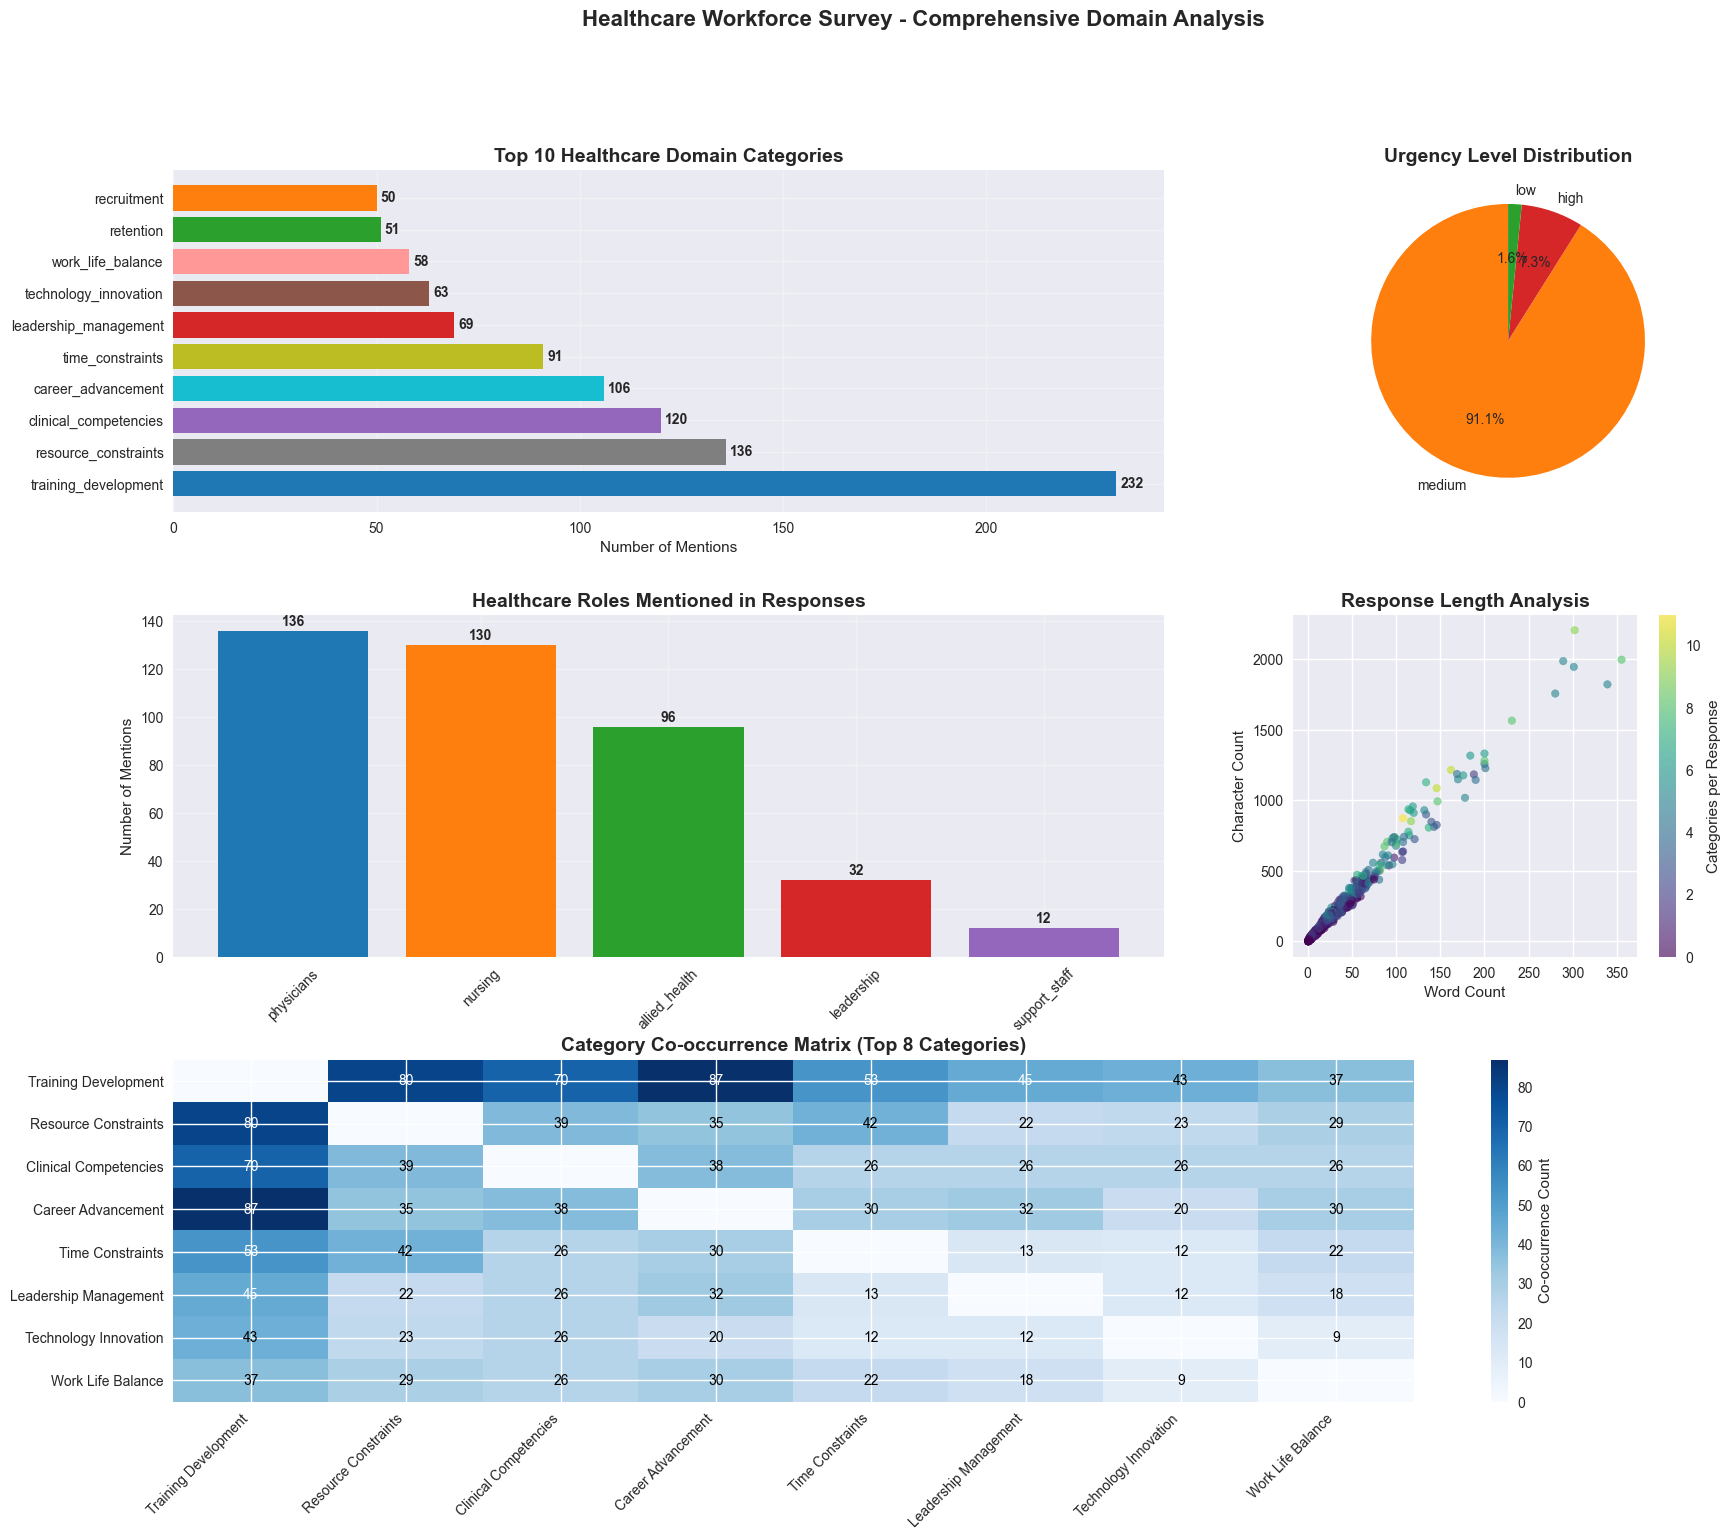

🔍 DETAILED HEALTHCARE DOMAIN INSIGHTS
\n📈 TOP PRIORITY AREAS:
1. Training Development: 232 mentions (37.0%)
   Training, education, and skill development needs
2. Resource Constraints: 136 mentions (21.7%)
   Financial and resource limitations
3. Clinical Competencies: 120 mentions (19.1%)
   Clinical skills and patient care competencies
4. Career Advancement: 106 mentions (16.9%)
   Career development and advancement opportunities
5. Time Constraints: 91 mentions (14.5%)
   Time and scheduling challenges
\n⚡ URGENCY ANALYSIS:
• Medium: 571 responses (91.1%)
• High: 46 responses (7.3%)
• Low: 10 responses (1.6%)
\n👥 HEALTHCARE WORKFORCE FOCUS:
• Physicians: 136 mentions (21.7%)
• Nursing: 130 mentions (20.7%)
• Allied Health: 96 mentions (15.3%)
• Leadership: 32 mentions (5.1%)
• Support Staff: 12 mentions (1.9%)
\n🤝 CATEGORY COMBINATIONS (Top Co-occurring):
• Career Advancement + Training Development: 87 times
• Resource Constraints + Training Development: 80 times
• Clinical Competen

In [16]:
# Comprehensive analysis of healthcare domains
all_categories = []
all_urgencies = []
all_roles = []

for categories_list in tagged_df['categories']:
    all_categories.extend(categories_list)

for urgency in tagged_df['urgency_level']:
    all_urgencies.append(urgency)

for roles_list in tagged_df['healthcare_roles']:
    all_roles.extend(roles_list)

category_counts = Counter(all_categories)
urgency_counts = Counter(all_urgencies)
role_counts = Counter(all_roles)

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 16))

# Create a 3x3 grid for multiple visualizations
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top healthcare categories (horizontal bar)
ax1 = fig.add_subplot(gs[0, :2])
top_categories = dict(category_counts.most_common(10))
colors = [healthcare_categories[cat]['color'] for cat in top_categories.keys()]
bars = ax1.barh(list(top_categories.keys()), list(top_categories.values()), color=colors)
ax1.set_xlabel('Number of Mentions')
ax1.set_title('Top 10 Healthcare Domain Categories', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, top_categories.values()):
    ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             str(value), va='center', fontweight='bold')

# 2. Urgency distribution (pie chart)
ax2 = fig.add_subplot(gs[0, 2])
urgency_colors = {'high': '#d62728', 'medium': '#ff7f0e', 'low': '#2ca02c', 'unknown': '#7f7f7f'}
colors = [urgency_colors.get(level, '#1f77b4') for level in urgency_counts.keys()]
wedges, texts, autotexts = ax2.pie(urgency_counts.values(), labels=urgency_counts.keys(), 
                                  autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Urgency Level Distribution', fontsize=14, fontweight='bold')

# 3. Healthcare roles (bar chart)
ax3 = fig.add_subplot(gs[1, :2])
role_data = dict(role_counts.most_common())
bars = ax3.bar(role_data.keys(), role_data.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax3.set_ylabel('Number of Mentions')
ax3.set_title('Healthcare Roles Mentioned in Responses', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 4. Response characteristics scatter plot
ax4 = fig.add_subplot(gs[1, 2])
scatter = ax4.scatter(tagged_df['word_count'], tagged_df['response_length'], 
                     alpha=0.6, c=tagged_df['category_count'], cmap='viridis', s=30)
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Character Count')
ax4.set_title('Response Length Analysis', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Categories per Response')

# 5. Category co-occurrence heatmap
ax5 = fig.add_subplot(gs[2, :])
# Create co-occurrence matrix
from itertools import combinations
cooccurrence = defaultdict(int)
for categories_list in tagged_df['categories']:
    if len(categories_list) > 1:
        for cat1, cat2 in combinations(categories_list, 2):
            pair = tuple(sorted([cat1, cat2]))
            cooccurrence[pair] += 1

# Convert to matrix format for top categories
top_cats = [cat for cat, _ in category_counts.most_common(8)]
cooc_matrix = np.zeros((len(top_cats), len(top_cats)))

for i, cat1 in enumerate(top_cats):
    for j, cat2 in enumerate(top_cats):
        if i != j:
            pair = tuple(sorted([cat1, cat2]))
            cooc_matrix[i, j] = cooccurrence.get(pair, 0)

im = ax5.imshow(cooc_matrix, cmap='Blues', aspect='auto')
ax5.set_xticks(range(len(top_cats)))
ax5.set_yticks(range(len(top_cats)))
ax5.set_xticklabels([cat.replace('_', ' ').title() for cat in top_cats], rotation=45, ha='right')
ax5.set_yticklabels([cat.replace('_', ' ').title() for cat in top_cats])
ax5.set_title('Category Co-occurrence Matrix (Top 8 Categories)', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(top_cats)):
    for j in range(len(top_cats)):
        if cooc_matrix[i, j] > 0:
            ax5.text(j, i, int(cooc_matrix[i, j]), ha='center', va='center', 
                    color='white' if cooc_matrix[i, j] > cooc_matrix.max()/2 else 'black')

plt.colorbar(im, ax=ax5, label='Co-occurrence Count')

plt.suptitle('Healthcare Workforce Survey - Comprehensive Domain Analysis', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print detailed insights
print("🔍 DETAILED HEALTHCARE DOMAIN INSIGHTS")
print("=" * 60)

print(f"\\n📈 TOP PRIORITY AREAS:")
for i, (category, count) in enumerate(category_counts.most_common(5), 1):
    description = healthcare_categories[category]['description']
    percentage = (count / len(tagged_df)) * 100
    print(f"{i}. {category.replace('_', ' ').title()}: {count} mentions ({percentage:.1f}%)")
    print(f"   {description}")

print(f"\\n⚡ URGENCY ANALYSIS:")
total_responses = len(tagged_df)
for urgency, count in urgency_counts.most_common():
    percentage = (count / total_responses) * 100
    print(f"• {urgency.title()}: {count} responses ({percentage:.1f}%)")

print(f"\\n👥 HEALTHCARE WORKFORCE FOCUS:")
for role, count in role_counts.most_common():
    percentage = (count / len(tagged_df)) * 100
    print(f"• {role.replace('_', ' ').title()}: {count} mentions ({percentage:.1f}%)")

print(f"\\n🤝 CATEGORY COMBINATIONS (Top Co-occurring):")
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]
for (cat1, cat2), count in top_cooccurrences:
    print(f"• {cat1.replace('_', ' ').title()} + {cat2.replace('_', ' ').title()}: {count} times")


## 6. Geographic and Organizational Analysis


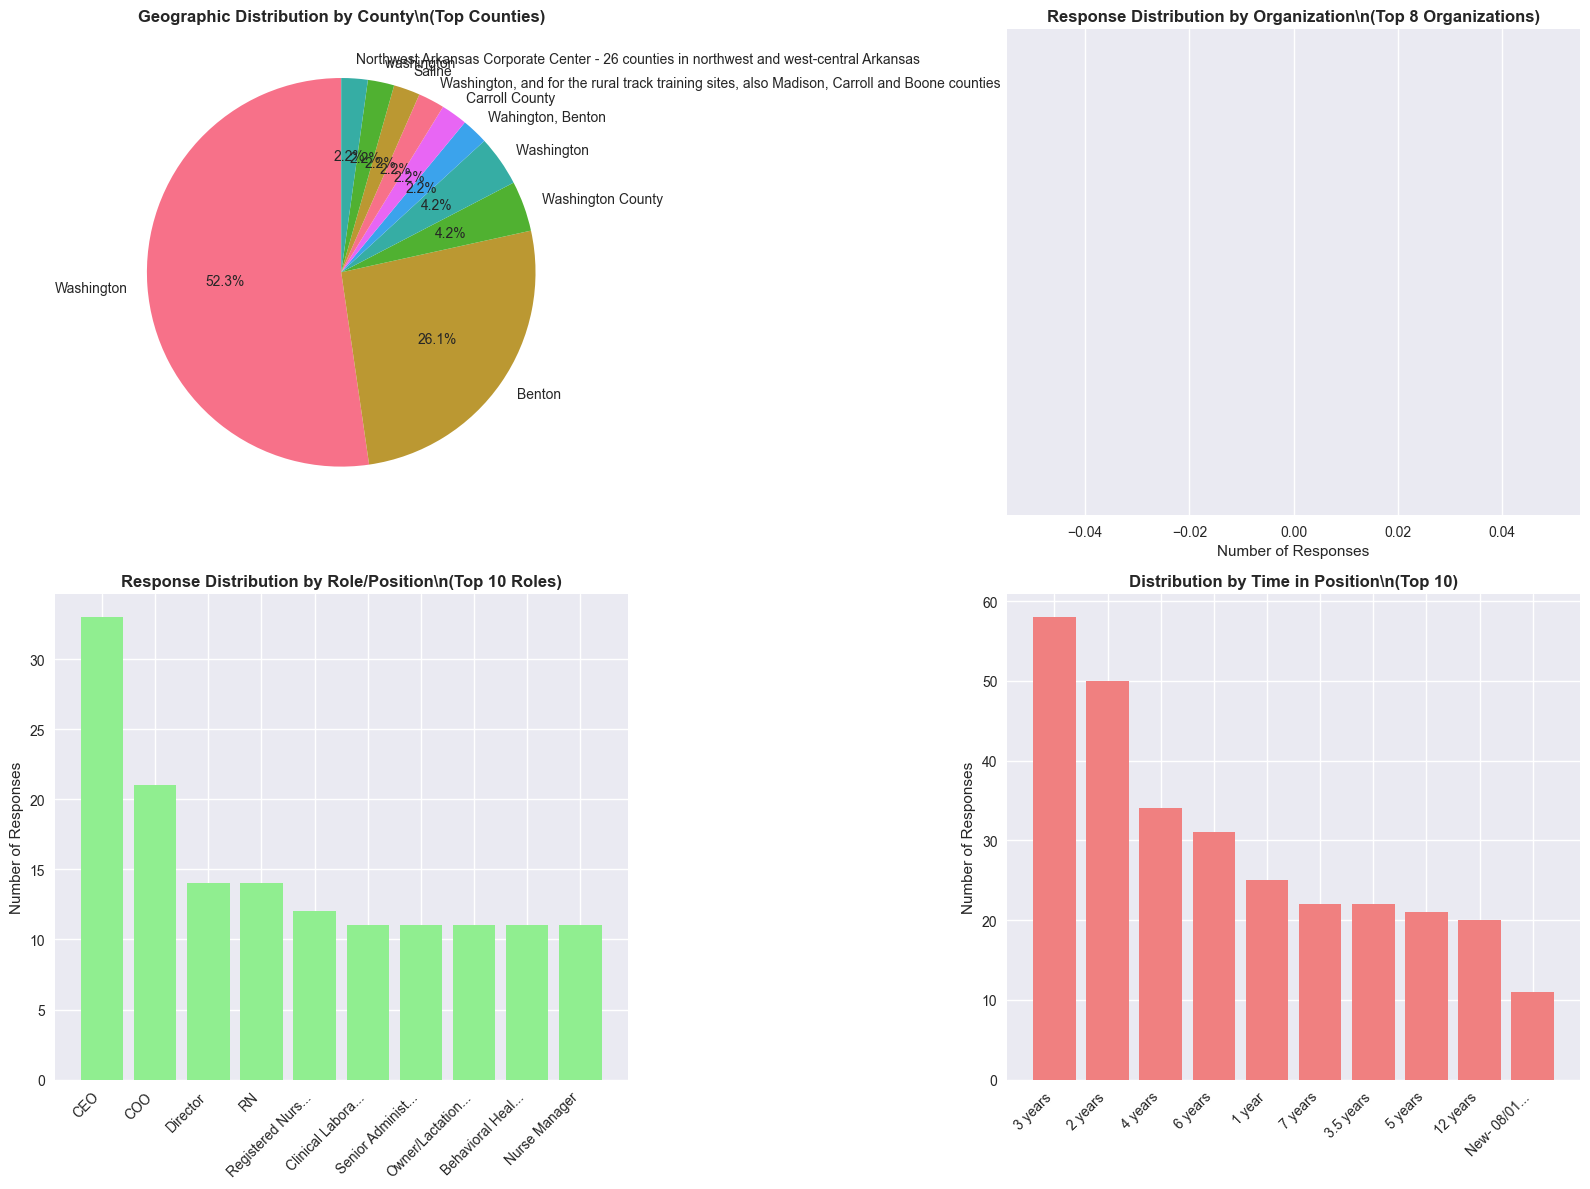

🗺️ GEOGRAPHIC AND ORGANIZATIONAL INSIGHTS
\n📍 COUNTY-LEVEL ANALYSIS:
\n12 Counties in Arkansas-Madison, Carroll, Newton, Boone, Searcy, Marion, Baxter, Stone, Van Buren, Conway, Clebourn, Faulkner  County:
  📊 Total responses: 10
  🚨 High urgency responses: 2
  🏥 Top categories: Training Development, Clinical Competencies, Career Advancement
\nBenton County:
  📊 Total responses: 131
  🚨 High urgency responses: 9
  🏥 Top categories: Training Development, Resource Constraints, Clinical Competencies
\nBenton & Washington County:
  📊 Total responses: 10
  🚨 High urgency responses: 1
  🏥 Top categories: Resource Constraints, Work Life Balance, Training Development
\nBenton, Washington, Madison, and Carroll County:
  📊 Total responses: 11
  🚨 High urgency responses: 1
  🏥 Top categories: Leadership Management, Training Development, Career Advancement
\nBenton/Washington County:
  📊 Total responses: 10
  🚨 High urgency responses: 1
  🏥 Top categories: Training Development, Career Advancement,

In [17]:
# Geographic and organizational analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. County distribution
county_counts = tagged_df['county'].value_counts().head(10)
county_counts = county_counts[county_counts.index != 'Unknown']  # Remove Unknown
ax1.pie(county_counts.values, labels=county_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Geographic Distribution by County\\n(Top Counties)', fontsize=12, fontweight='bold')

# 2. Organization analysis
org_counts = tagged_df['organization'].value_counts().head(8)
org_counts = org_counts[org_counts.index != 'Unknown']  # Remove Unknown
ax2.barh(range(len(org_counts)), org_counts.values, color='lightblue')
ax2.set_yticks(range(len(org_counts)))
ax2.set_yticklabels([org[:25] + '...' if len(org) > 25 else org for org in org_counts.index])
ax2.set_xlabel('Number of Responses')
ax2.set_title('Response Distribution by Organization\\n(Top 8 Organizations)', fontsize=12, fontweight='bold')

# 3. Role/Position distribution
role_counts = tagged_df['role_position'].value_counts().head(10)
role_counts = role_counts[role_counts.index != 'Unknown']
ax3.bar(range(len(role_counts)), role_counts.values, color='lightgreen')
ax3.set_xticks(range(len(role_counts)))
ax3.set_xticklabels([role[:15] + '...' if len(role) > 15 else role for role in role_counts.index], 
                   rotation=45, ha='right')
ax3.set_ylabel('Number of Responses')
ax3.set_title('Response Distribution by Role/Position\\n(Top 10 Roles)', fontsize=12, fontweight='bold')

# 4. Experience level analysis
time_counts = tagged_df['time_in_position'].value_counts().head(10)
time_counts = time_counts[time_counts.index != 'Unknown']
ax4.bar(range(len(time_counts)), time_counts.values, color='lightcoral')
ax4.set_xticks(range(len(time_counts)))
ax4.set_xticklabels([time[:10] + '...' if len(time) > 10 else time for time in time_counts.index], 
                   rotation=45, ha='right')
ax4.set_ylabel('Number of Responses')
ax4.set_title('Distribution by Time in Position\\n(Top 10)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed geographic analysis
print("🗺️ GEOGRAPHIC AND ORGANIZATIONAL INSIGHTS")
print("=" * 60)

# County-level analysis
county_analysis = tagged_df.groupby('county').agg({
    'response_id': 'count',
    'categories': lambda x: [cat for sublist in x for cat in sublist],
    'urgency_level': lambda x: list(x),
    'top_category': lambda x: list(x)
}).rename(columns={'response_id': 'response_count'})

county_analysis['top_categories'] = county_analysis['categories'].apply(
    lambda x: dict(Counter(x).most_common(3))
)

county_analysis['high_urgency_count'] = county_analysis['urgency_level'].apply(
    lambda x: sum(1 for urgency in x if urgency == 'high')
)

print("\\n📍 COUNTY-LEVEL ANALYSIS:")
for county, data in county_analysis.head(5).iterrows():
    if county != 'Unknown' and data['response_count'] > 2:
        print(f"\\n{county} County:")
        print(f"  📊 Total responses: {data['response_count']}")
        print(f"  🚨 High urgency responses: {data['high_urgency_count']}")
        if data['top_categories']:
            top_3_cats = list(data['top_categories'].keys())[:3]
            print(f"  🏥 Top categories: {', '.join([cat.replace('_', ' ').title() for cat in top_3_cats])}")

# Organization-level analysis
print("\\n🏢 ORGANIZATIONAL ANALYSIS:")
org_analysis = tagged_df.groupby('organization').agg({
    'response_id': 'count',
    'categories': lambda x: [cat for sublist in x for cat in sublist],
    'urgency_level': lambda x: list(x)
}).rename(columns={'response_id': 'response_count'})

org_analysis['top_category'] = org_analysis['categories'].apply(
    lambda x: Counter(x).most_common(1)[0][0] if x else 'none'
)

for org, data in org_analysis.head(5).iterrows():
    if org != 'Unknown' and data['response_count'] > 3:
        urgency_dist = Counter(data['urgency_level'])
        print(f"\\n{org}:")
        print(f"  📊 Responses: {data['response_count']}")
        print(f"  🎯 Primary focus: {data['top_category'].replace('_', ' ').title()}")
        print(f"  ⚡ Urgency: {urgency_dist.get('high', 0)} high, {urgency_dist.get('medium', 0)} medium, {urgency_dist.get('low', 0)} low")


## 7. Priority Matrix and Strategic Recommendations


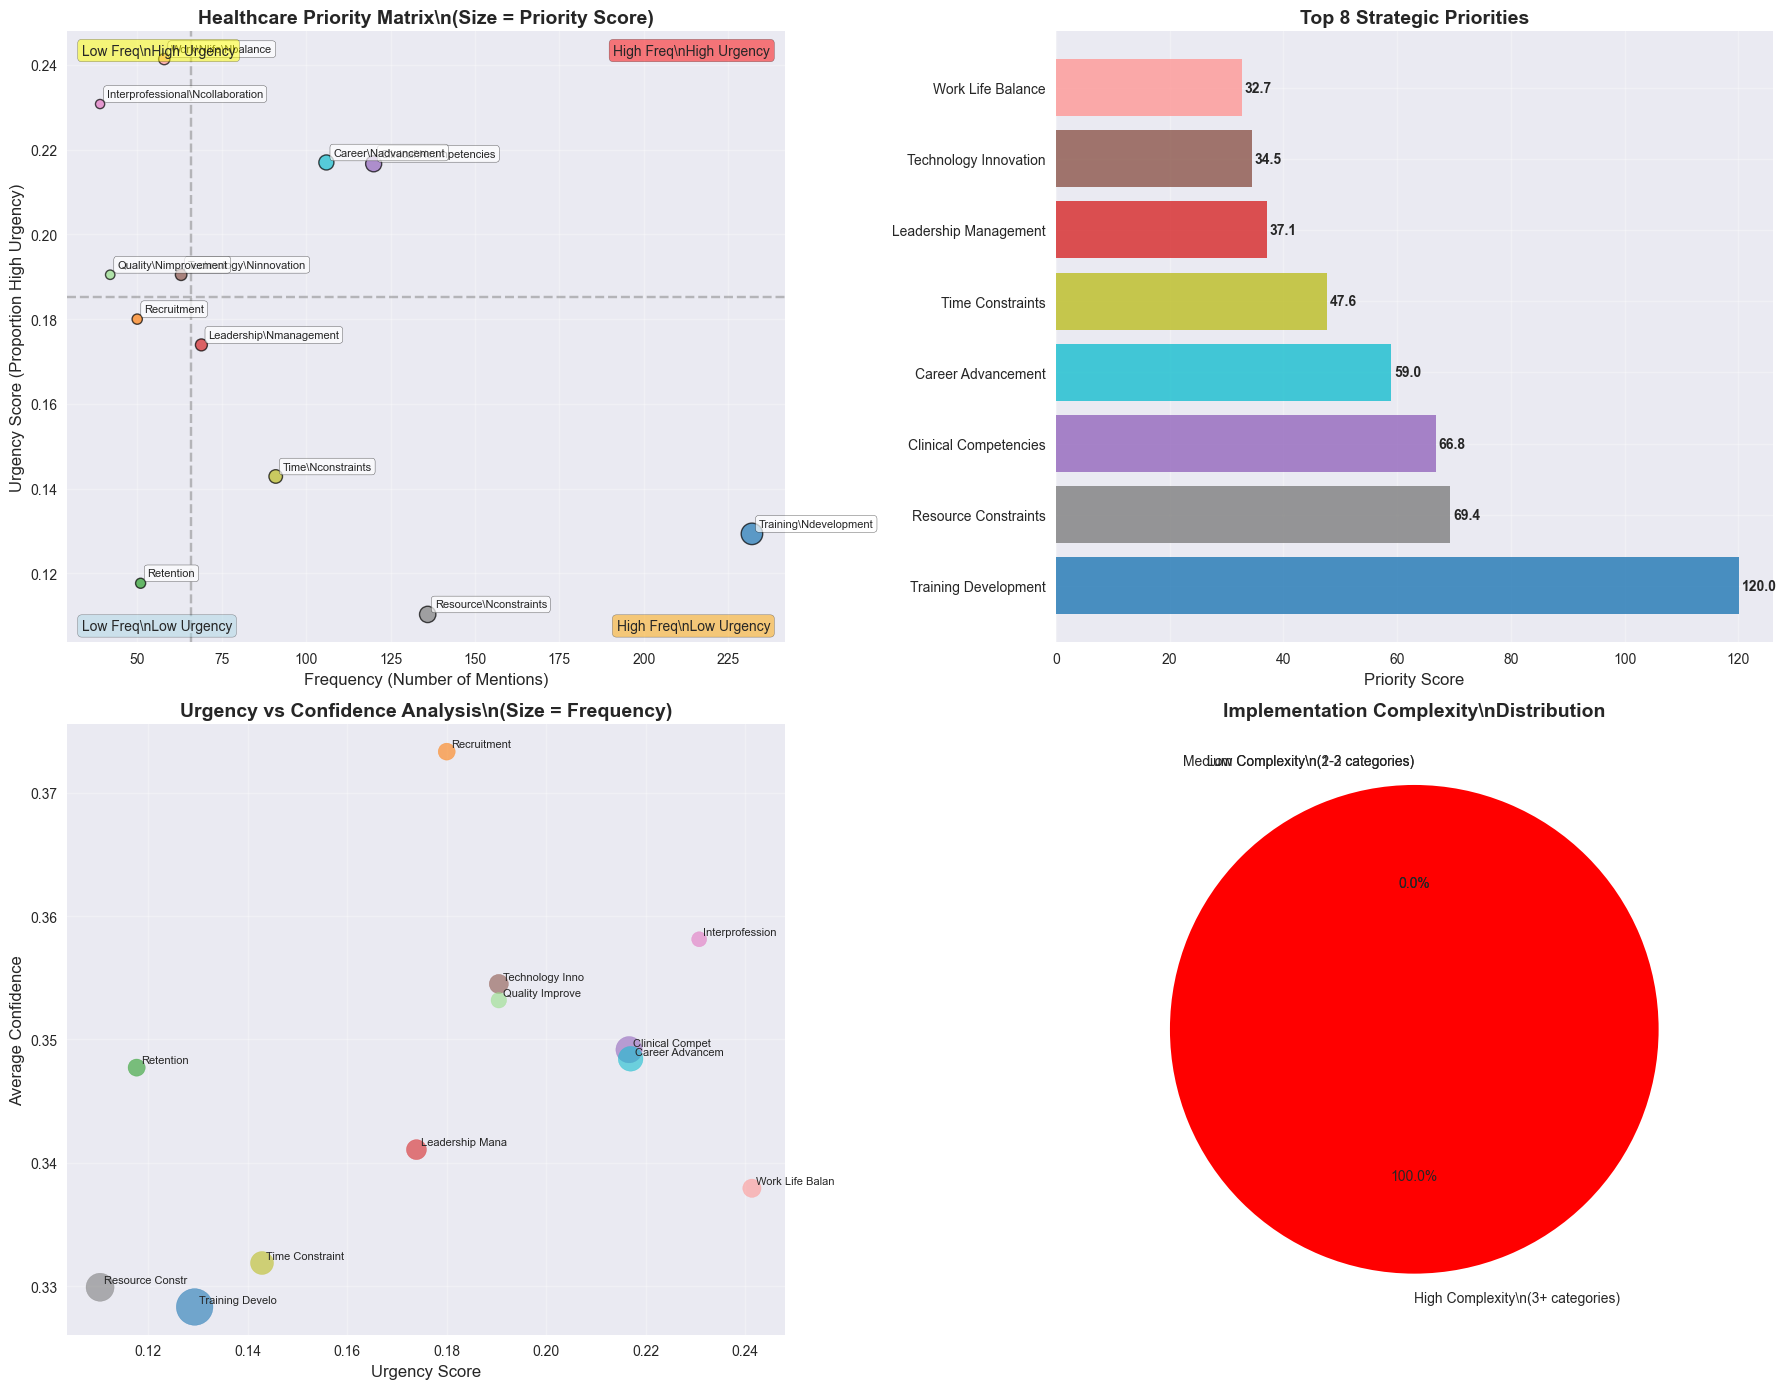

🎯 STRATEGIC PRIORITY RECOMMENDATIONS
\n🔥 TOP 5 IMMEDIATE PRIORITIES (High Impact, High Urgency):
\n1. Training Development
   📝 Description: Training, education, and skill development needs
   📊 Frequency: 232 mentions
   ⚡ Urgency: 0.13 (🟡 HIGH)
   🎯 Priority Score: 120.0
\n2. Resource Constraints
   📝 Description: Financial and resource limitations
   📊 Frequency: 136 mentions
   ⚡ Urgency: 0.11 (🟡 HIGH)
   🎯 Priority Score: 69.4
\n3. Clinical Competencies
   📝 Description: Clinical skills and patient care competencies
   📊 Frequency: 120 mentions
   ⚡ Urgency: 0.22 (🔴 CRITICAL)
   🎯 Priority Score: 66.8
\n4. Career Advancement
   📝 Description: Career development and advancement opportunities
   📊 Frequency: 106 mentions
   ⚡ Urgency: 0.22 (🔴 CRITICAL)
   🎯 Priority Score: 59.0
\n5. Time Constraints
   📝 Description: Time and scheduling challenges
   📊 Frequency: 91 mentions
   ⚡ Urgency: 0.14 (🟡 HIGH)
   🎯 Priority Score: 47.6
\n\n📋 STRATEGIC QUADRANT ANALYSIS:
\n🔴 HIGH FREQUENCY +

In [18]:
# Create comprehensive priority matrix analysis
priority_analysis = []

for category, info in healthcare_categories.items():
    # Get all responses with this category
    category_responses = tagged_df[tagged_df['categories'].apply(lambda x: category in x)]
    
    if len(category_responses) > 0:
        frequency = len(category_responses)
        high_urgency_count = sum(1 for urgency in category_responses['urgency_level'] if urgency == 'high')
        urgency_score = high_urgency_count / frequency if frequency > 0 else 0
        
        # Calculate average confidence for urgency assessments
        avg_confidence = category_responses['urgency_confidence'].mean()
        
        # Calculate complexity score based on average categories per response
        avg_complexity = category_responses['category_count'].mean()
        
        # Calculate priority score with multiple factors
        priority_score = (frequency * 0.4 +               # Frequency weight
                         urgency_score * frequency * 0.4 + # Urgency impact
                         avg_confidence * frequency * 0.2) # Confidence weight
        
        priority_analysis.append({
            'category': category,
            'description': info['description'],
            'frequency': frequency,
            'urgency_score': urgency_score,
            'high_urgency_count': high_urgency_count,
            'avg_confidence': avg_confidence,
            'avg_complexity': avg_complexity,
            'priority_score': priority_score,
            'color': info['color']
        })

priority_df = pd.DataFrame(priority_analysis).sort_values('priority_score', ascending=False)

# Create comprehensive priority visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Priority Matrix Scatter Plot
sizes = priority_df['priority_score'] * 2
colors = [row['color'] for _, row in priority_df.iterrows()]

scatter = ax1.scatter(priority_df['frequency'], priority_df['urgency_score'], 
                     s=sizes, alpha=0.7, c=colors, edgecolors='black', linewidth=1)

# Add quadrant lines
ax1.axhline(y=priority_df['urgency_score'].median(), color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=priority_df['frequency'].median(), color='gray', linestyle='--', alpha=0.5)

# Add labels for all categories
for _, row in priority_df.iterrows():
    ax1.annotate(row['category'].replace('_', '\\n').title(), 
                (row['frequency'], row['urgency_score']),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax1.set_xlabel('Frequency (Number of Mentions)', fontsize=12)
ax1.set_ylabel('Urgency Score (Proportion High Urgency)', fontsize=12)
ax1.set_title('Healthcare Priority Matrix\\n(Size = Priority Score)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add quadrant labels
ax1.text(0.02, 0.98, 'Low Freq\\nHigh Urgency', transform=ax1.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.98, 0.98, 'High Freq\\nHigh Urgency', transform=ax1.transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(0.02, 0.02, 'Low Freq\\nLow Urgency', transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax1.text(0.98, 0.02, 'High Freq\\nLow Urgency', transform=ax1.transAxes, 
         horizontalalignment='right', 
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

# 2. Top Priorities Bar Chart
top_priorities = priority_df.head(8)
bars = ax2.barh(range(len(top_priorities)), top_priorities['priority_score'], 
                color=[row['color'] for _, row in top_priorities.iterrows()], alpha=0.8)
ax2.set_yticks(range(len(top_priorities)))
ax2.set_yticklabels([cat.replace('_', ' ').title() for cat in top_priorities['category']])
ax2.set_xlabel('Priority Score', fontsize=12)
ax2.set_title('Top 8 Strategic Priorities', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_priorities['priority_score'])):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{value:.1f}', va='center', fontweight='bold')

# 3. Urgency vs Confidence Analysis
ax3.scatter(priority_df['urgency_score'], priority_df['avg_confidence'], 
           s=priority_df['frequency']*3, alpha=0.6, 
           c=[row['color'] for _, row in priority_df.iterrows()])

for _, row in priority_df.iterrows():
    if row['urgency_score'] > 0.1 or row['avg_confidence'] > 0.6:  # Label high urgency or high confidence
        ax3.annotate(row['category'].replace('_', ' ').title()[:15], 
                    (row['urgency_score'], row['avg_confidence']),
                    xytext=(3, 3), textcoords='offset points', fontsize=8)

ax3.set_xlabel('Urgency Score', fontsize=12)
ax3.set_ylabel('Average Confidence', fontsize=12)
ax3.set_title('Urgency vs Confidence Analysis\\n(Size = Frequency)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Implementation Complexity Analysis
complexity_categories = ['Low Complexity\\n(1-2 categories)', 'Medium Complexity\\n(2-3 categories)', 
                        'High Complexity\\n(3+ categories)']
complexity_counts = []

for threshold in [2, 3, 10]:  # Define complexity thresholds
    count = len(priority_df[priority_df['avg_complexity'] < threshold])
    complexity_counts.append(count)

# Adjust counts to be cumulative differences
complexity_counts = [complexity_counts[0], 
                    complexity_counts[1] - complexity_counts[0],
                    len(priority_df) - complexity_counts[1]]

colors_complexity = ['lightgreen', 'orange', 'red']
ax4.pie(complexity_counts, labels=complexity_categories, autopct='%1.1f%%', 
        colors=colors_complexity, startangle=90)
ax4.set_title('Implementation Complexity\\nDistribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Strategic recommendations
print("🎯 STRATEGIC PRIORITY RECOMMENDATIONS")
print("=" * 70)

print("\\n🔥 TOP 5 IMMEDIATE PRIORITIES (High Impact, High Urgency):")
for i, (_, row) in enumerate(priority_df.head(5).iterrows(), 1):
    impact_level = "🔴 CRITICAL" if row['urgency_score'] > 0.15 else "🟡 HIGH" if row['urgency_score'] > 0.05 else "🟢 MEDIUM"
    print(f"\\n{i}. {row['category'].replace('_', ' ').title()}")
    print(f"   📝 Description: {row['description']}")
    print(f"   📊 Frequency: {row['frequency']} mentions")
    print(f"   ⚡ Urgency: {row['urgency_score']:.2f} ({impact_level})")
    print(f"   🎯 Priority Score: {row['priority_score']:.1f}")

# Quadrant analysis
print("\\n\\n📋 STRATEGIC QUADRANT ANALYSIS:")

high_freq_high_urgency = priority_df[(priority_df['frequency'] > priority_df['frequency'].median()) & 
                                     (priority_df['urgency_score'] > priority_df['urgency_score'].median())]
high_freq_low_urgency = priority_df[(priority_df['frequency'] > priority_df['frequency'].median()) & 
                                   (priority_df['urgency_score'] <= priority_df['urgency_score'].median())]
low_freq_high_urgency = priority_df[(priority_df['frequency'] <= priority_df['frequency'].median()) & 
                                   (priority_df['urgency_score'] > priority_df['urgency_score'].median())]

print(f"\\n🔴 HIGH FREQUENCY + HIGH URGENCY (Immediate Action Required):")
for _, row in high_freq_high_urgency.iterrows():
    print(f"   • {row['category'].replace('_', ' ').title()}")

print(f"\\n🟡 HIGH FREQUENCY + LOW URGENCY (Systematic Improvement):")
for _, row in high_freq_low_urgency.iterrows():
    print(f"   • {row['category'].replace('_', ' ').title()}")

print(f"\\n🟠 LOW FREQUENCY + HIGH URGENCY (Targeted Intervention):")
for _, row in low_freq_high_urgency.iterrows():
    print(f"   • {row['category'].replace('_', ' ').title()}")

# Implementation timeline recommendations
print("\\n\\n⏰ RECOMMENDED IMPLEMENTATION TIMELINE:")
print("\\n📅 QUARTER 1 (Immediate - 0-3 months):")
q1_priorities = priority_df.head(3)
for _, row in q1_priorities.iterrows():
    print(f"   • Launch {row['category'].replace('_', ' ').title()} initiatives")

print("\\n📅 QUARTER 2-3 (Short-term - 3-9 months):")
q2_priorities = priority_df.iloc[3:6]
for _, row in q2_priorities.iterrows():
    print(f"   • Develop {row['category'].replace('_', ' ').title()} programs")

print("\\n📅 QUARTER 4+ (Long-term - 9+ months):")
q3_priorities = priority_df.iloc[6:9]
for _, row in q3_priorities.iterrows():
    print(f"   • Establish {row['category'].replace('_', ' ').title()} infrastructure")


## 8. Interactive Analysis Functions


In [24]:
# Define comprehensive interactive analysis functions
def search_responses(keyword, tagged_df=tagged_df, max_results=5):
    """Search for responses containing a specific keyword with enhanced analysis"""
    matches = tagged_df[tagged_df['response_text'].str.contains(keyword, case=False, na=False)]
    
    print(f"🔍 Found {len(matches)} responses containing '{keyword}':")
    print("=" * 60)
    
    if len(matches) == 0:
        print("No matches found. Try different keywords or check spelling.")
        return matches
    
    # Show summary statistics
    category_summary = {}
    for categories_list in matches['categories']:
        for cat in categories_list:
            category_summary[cat] = category_summary.get(cat, 0) + 1
    
    urgency_summary = matches['urgency_level'].value_counts()
    org_summary = matches['organization'].value_counts()
    
    print(f"\\n📊 SUMMARY STATISTICS:")
    print(f"   Most common categories: {', '.join([cat.replace('_', ' ').title() for cat in sorted(category_summary.keys(), key=category_summary.get, reverse=True)[:3]])}")
    print(f"   Urgency distribution: {dict(urgency_summary)}")
    print(f"   Top organizations: {', '.join(org_summary.head(3).index.tolist())}")
    
    print(f"\\n📝 SAMPLE RESPONSES:")
    for i, (_, row) in enumerate(matches.head(max_results).iterrows(), 1):
        print(f"\\n{i}. Question: {row['question_short'][:50]}...")
        print(f"   Organization: {row['organization']}")
        print(f"   Categories: {', '.join([cat.replace('_', ' ').title() for cat in row['categories']])}")
        print(f"   Urgency: {row['urgency_level'].title()} (confidence: {row['urgency_confidence']:.2f})")
        print(f"   Response: {row['response_text'][:200]}{'...' if len(row['response_text']) > 200 else ''}")
        print("-" * 40)
    
    if len(matches) > max_results:
        print(f"\\n... and {len(matches) - max_results} more responses")
    
    return matches

def filter_by_category(category, tagged_df=tagged_df, show_details=True):
    """Filter responses by healthcare category with detailed analysis"""
    if category not in healthcare_categories:
        print(f"❌ Category '{category}' not found. Available categories:")
        for cat in healthcare_categories.keys():
            print(f"   • {cat}")
        return pd.DataFrame()
    
    filtered = tagged_df[tagged_df['categories'].apply(lambda x: category in x)]
    
    print(f"🏥 Analysis for category: {category.replace('_', ' ').title()}")
    print(f"📝 Description: {healthcare_categories[category]['description']}")
    print("=" * 60)
    
    if len(filtered) == 0:
        print("No responses found for this category.")
        return filtered
    
    print(f"\\n📊 CATEGORY STATISTICS:")
    print(f"   Total responses: {len(filtered)}")
    print(f"   Percentage of all responses: {len(filtered)/len(tagged_df)*100:.1f}%")
    
    # Urgency analysis
    urgency_dist = filtered['urgency_level'].value_counts()
    print(f"\\n⚡ URGENCY DISTRIBUTION:")
    for urgency, count in urgency_dist.items():
        percentage = count / len(filtered) * 100
        urgency_emoji = "🔴" if urgency == "high" else "🟡" if urgency == "medium" else "🟢"
        print(f"   {urgency_emoji} {urgency.title()}: {count} ({percentage:.1f}%)")
    
    # Geographic distribution
    geo_dist = filtered['county'].value_counts().head(5)
    geo_dist = geo_dist[geo_dist.index != 'Unknown']
    if len(geo_dist) > 0:
        print(f"\\n📍 GEOGRAPHIC DISTRIBUTION:")
        for county, count in geo_dist.items():
            print(f"   • {county}: {count} responses")
    
    # Organizational analysis
    org_dist = filtered['organization'].value_counts().head(5)
    org_dist = org_dist[org_dist.index != 'Unknown']
    if len(org_dist) > 0:
        print(f"\\n🏢 ORGANIZATIONAL DISTRIBUTION:")
        for org, count in org_dist.items():
            print(f"   • {org[:30]}{'...' if len(org) > 30 else ''}: {count} responses")
    
    # Co-occurring categories
    cooccurring = {}
    for categories_list in filtered['categories']:
        for cat in categories_list:
            if cat != category:
                cooccurring[cat] = cooccurring.get(cat, 0) + 1
    
    if cooccurring:
        print(f"\\n🤝 FREQUENTLY CO-OCCURRING CATEGORIES:")
        for cat, count in sorted(cooccurring.items(), key=lambda x: x[1], reverse=True)[:3]:
            print(f"   • {cat.replace('_', ' ').title()}: {count} times")
    
    if show_details:
        print(f"\\n📝 SAMPLE RESPONSES:")
        # Show high urgency first, then others
        high_urgency = filtered[filtered['urgency_level'] == 'high']
        other_responses = filtered[filtered['urgency_level'] != 'high']
        
        sample_responses = pd.concat([high_urgency.head(2), other_responses.head(3)])
        
        for i, (_, row) in enumerate(sample_responses.iterrows(), 1):
            urgency_emoji = "🔴" if row['urgency_level'] == "high" else "🟡" if row['urgency_level'] == "medium" else "🟢"
            print(f"\\n{i}. {urgency_emoji} {row['response_text'][:150]}{'...' if len(row['response_text']) > 150 else ''}")
            print(f"   Organization: {row['organization']}, Question: {row['question_short'][:40]}...")
    
    return filtered

def analyze_organization(org_name, tagged_df=tagged_df):
    """Comprehensive analysis of responses from a specific organization"""
    org_data = tagged_df[tagged_df['organization'].str.contains(org_name, case=False, na=False)]
    
    if len(org_data) == 0:
        print(f"❌ No responses found for organization containing '{org_name}'")
        print(f"\\n🏢 Available organizations:")
        orgs = tagged_df['organization'].value_counts()
        orgs = orgs[orgs.index != 'Unknown']
        for org, count in orgs.head(10).items():
            print(f"   • {org} ({count} responses)")
        return None
    
    # Get exact organization names
    org_names = org_data['organization'].unique()
    
    for org in org_names:
        if org == 'Unknown':
            continue
            
        org_specific = org_data[org_data['organization'] == org]
        
        print(f"🏢 ANALYSIS FOR: {org}")
        print("=" * 60)
        print(f"📊 Total responses: {len(org_specific)}")
        
        # Category analysis
        all_cats = [cat for sublist in org_specific['categories'] for cat in sublist]
        cat_counts = Counter(all_cats)
        
        print(f"\\n🎯 TOP FOCUS AREAS:")
        for cat, count in cat_counts.most_common(5):
            percentage = count / len(org_specific) * 100
            print(f"   • {cat.replace('_', ' ').title()}: {count} mentions ({percentage:.1f}%)")
        
        # Urgency analysis
        urgency_dist = org_specific['urgency_level'].value_counts()
        print(f"\\n⚡ URGENCY PROFILE:")
        total_responses = len(org_specific)
        for urgency in ['high', 'medium', 'low']:
            count = urgency_dist.get(urgency, 0)
            percentage = count / total_responses * 100
            urgency_emoji = "🔴" if urgency == "high" else "🟡" if urgency == "medium" else "🟢"
            print(f"   {urgency_emoji} {urgency.title()}: {count} ({percentage:.1f}%)")
        
        # Role analysis
        role_dist = org_specific['role_position'].value_counts()
        role_dist = role_dist[role_dist.index != 'Unknown']
        if len(role_dist) > 0:
            print(f"\\n👥 RESPONDENT ROLES:")
            for role, count in role_dist.head(5).items():
                print(f"   • {role}: {count} responses")
        
        # Response characteristics
        avg_length = org_specific['response_length'].mean()
        avg_words = org_specific['word_count'].mean()
        avg_categories = org_specific['category_count'].mean()
        
        print(f"\\n📝 RESPONSE CHARACTERISTICS:")
        print(f"   • Average response length: {avg_length:.0f} characters")
        print(f"   • Average word count: {avg_words:.0f} words")
        print(f"   • Average categories per response: {avg_categories:.1f}")
        
        # Show most urgent response
        high_urgency_responses = org_specific[org_specific['urgency_level'] == 'high']
        if len(high_urgency_responses) > 0:
            print(f"\\n🚨 HIGHEST URGENCY RESPONSE:")
            urgent_response = high_urgency_responses.iloc[0]
            print(f"   Question: {urgent_response['question_short']}")
            print(f"   Response: {urgent_response['response_text'][:200]}{'...' if len(urgent_response['response_text']) > 200 else ''}")
            print(f"   Categories: {', '.join([cat.replace('_', ' ').title() for cat in urgent_response['categories']])}")
        
        print("\\n" + "="*60 + "\\n")
    
    return org_data

def generate_insights_report(tagged_df=tagged_df):
    """Generate a comprehensive insights report"""
    print("📋 COMPREHENSIVE HEALTHCARE WORKFORCE INSIGHTS REPORT")
    print("=" * 70)
    
    # Executive summary
    total_responses = len(tagged_df)
    total_orgs = tagged_df['organization'].nunique()
    total_counties = tagged_df['county'].nunique()
    
    print(f"\\n📊 EXECUTIVE SUMMARY:")
    print(f"   • Total survey responses analyzed: {total_responses}")
    print(f"   • Organizations represented: {total_orgs}")
    print(f"   • Geographic coverage: {total_counties} counties")
    print(f"   • Average response length: {tagged_df['response_length'].mean():.0f} characters")
    
    # Top insights
    all_categories = [cat for sublist in tagged_df['categories'] for cat in sublist]
    category_counts = Counter(all_categories)
    urgency_counts = tagged_df['urgency_level'].value_counts()
    
    print(f"\\n🔍 KEY FINDINGS:")
    print(f"   1. Most critical need: {category_counts.most_common(1)[0][0].replace('_', ' ').title()} ({category_counts.most_common(1)[0][1]} mentions)")
    print(f"   2. Urgency level: {urgency_counts.get('high', 0)} high-urgency responses ({urgency_counts.get('high', 0)/total_responses*100:.1f}%)")
    print(f"   3. Primary geographic focus: {tagged_df['county'].value_counts().index[0]} County")
    print(f"   4. Most active organization: {tagged_df['organization'].value_counts().index[0]}")
    
    # Recommendations summary
    print(f"\\n💡 TOP 3 STRATEGIC RECOMMENDATIONS:")
    top_categories = [cat for cat, _ in category_counts.most_common(3)]
    for i, cat in enumerate(top_categories, 1):
        print(f"   {i}. Develop comprehensive {cat.replace('_', ' ')} programs")
    
    return {
        'total_responses': total_responses,
        'top_categories': dict(category_counts.most_common(5)),
        'urgency_distribution': dict(urgency_counts),
        'geographic_coverage': total_counties
    }

print("✅ INTERACTIVE ANALYSIS FUNCTIONS READY!")
print("=" * 50)
print("\\n🛠️ Available Functions:")
print("• search_responses('keyword') - Find responses containing specific terms")
print("• filter_by_category('category_name') - Analyze responses by domain")
print("• analyze_organization('org_name') - Organization-specific analysis")
print("• generate_insights_report() - Comprehensive summary report")
print("\\n💡 Try them out below!")


✅ INTERACTIVE ANALYSIS FUNCTIONS READY!
\n🛠️ Available Functions:
• search_responses('keyword') - Find responses containing specific terms
• filter_by_category('category_name') - Analyze responses by domain
• analyze_organization('org_name') - Organization-specific analysis
• generate_insights_report() - Comprehensive summary report
\n💡 Try them out below!


In [25]:
# Example usage of interactive functions
print("📝 EXAMPLE USAGE OF INTERACTIVE FUNCTIONS")
print("=" * 50)

# Example 1: Search for simulation-related responses
print("\n🔍 Example 1: Searching for 'simulation' responses:")
simulation_results = search_responses('simulation', max_results=3)


📝 EXAMPLE USAGE OF INTERACTIVE FUNCTIONS

🔍 Example 1: Searching for 'simulation' responses:
🔍 Found 14 responses containing 'simulation':
\n📊 SUMMARY STATISTICS:
   Most common categories: Training Development, Technology Innovation, Clinical Competencies
   Urgency distribution: {'medium': np.int64(11), 'high': np.int64(2), 'low': np.int64(1)}
   Top organizations: Unknown
\n📝 SAMPLE RESPONSES:
\n1. Question: Q11_How_do_you_currently_meet_the_training_needs_o...
   Organization: Unknown
   Categories: Training Development, Technology Innovation, Time Constraints, Retention, Clinical Competencies, Resource Constraints, Career Advancement
   Urgency: High (confidence: 0.33)
   Response: Arkansas Children's offers a variety of training modalities, including:

Online Training Modules: Accessible digital courses allow staff to engage in self-paced learning, accommodating diverse schedul...
----------------------------------------
\n2. Question: Q11_How_do_you_currently_meet_the_training_n

In [26]:
# Example 2: Analyze training and development category
print("\n🏥 Example 2: Training & Development Category Analysis:")
training_results = filter_by_category('training_development', show_details=False)



🏥 Example 2: Training & Development Category Analysis:
🏥 Analysis for category: Training Development
📝 Description: Training, education, and skill development needs
\n📊 CATEGORY STATISTICS:
   Total responses: 232
   Percentage of all responses: 37.0%
\n⚡ URGENCY DISTRIBUTION:
   🟡 Medium: 197 (84.9%)
   🔴 High: 30 (12.9%)
   🟢 Low: 5 (2.2%)
\n📍 GEOGRAPHIC DISTRIBUTION:
   • Washington: 78 responses
   • Benton: 52 responses
   • Washington : 10 responses
   • Washington County: 7 responses
   • Washington, and for the rural track training sites, also Madison, Carroll and Boone counties: 7 responses
\n🤝 FREQUENTLY CO-OCCURRING CATEGORIES:
   • Career Advancement: 87 times
   • Resource Constraints: 80 times
   • Clinical Competencies: 70 times
